### KDE(Kernel Density Estimation)의 이해

**seaborn의 distplot()을 이용하여 KDE 시각화**  
* distplot이 KDE 방식으로 plot 생성
https://seaborn.pydata.org/tutorial/distributions.html

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574 -2.55298982  0.6536186   0.8644362  -0.74216502
  2.26975462 -1.45436567  0.04575852 -0.18718385  1.53277921  1.46935877]


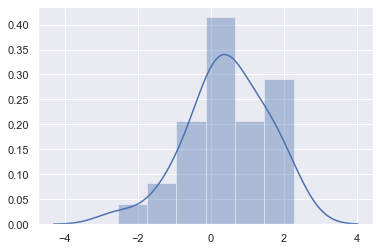

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(color_codes=True)

np.random.seed(0)
# loc 평균, scale 표준편차
x = np.random.normal(loc=0, scale=1, size=30)
print(x)
sns.distplot(x);

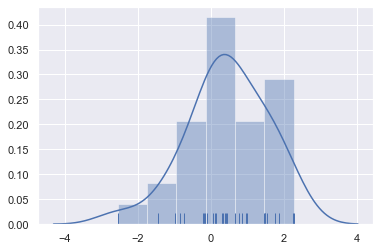

In [2]:
# rug 데이터 밀집 정도를 x축 위에 표시
sns.distplot(x, rug=True)

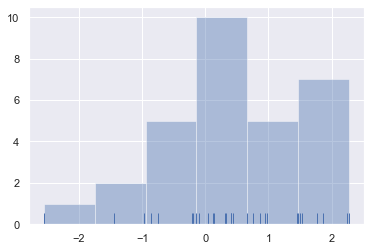

In [3]:
# 일반적인 hist + rug
sns.distplot(x, kde=False, rug=True)

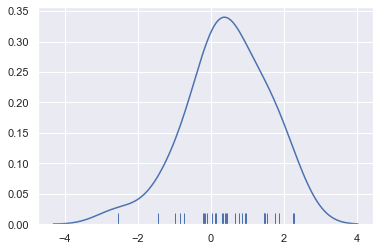

In [4]:
sns.distplot(x, hist=False, rug=True);

### Bandwidth에 따른 KDE 변화
<img src='../img/bandwidth.png/' width='70%' align='left' />

**개별 관측데이터에 대해 가우시안 커널 함수를 적용**

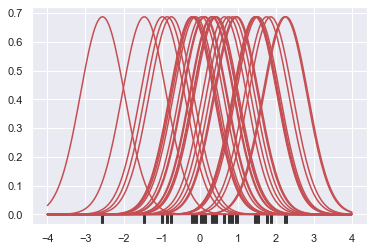

In [5]:
from scipy import stats

#x = np.random.normal(0, 1, size=30)
bandwidth = 1.06 * x.std() * x.size ** (-1 / 5.)
support = np.linspace(-4, 4, 200)

kernels = []
for x_i in x:
    kernel = stats.norm(x_i, bandwidth).pdf(support)
    kernels.append(kernel)
    plt.plot(support, kernel, color="r")

sns.rugplot(x, color=".2", linewidth=3);

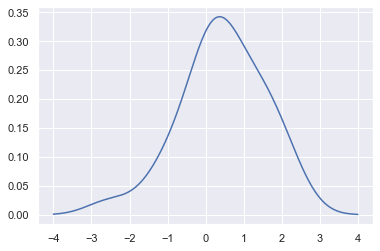

In [6]:
from scipy.integrate import trapz
density = np.sum(kernels, axis=0)
density /= trapz(density, support)
plt.plot(support, density)

# distplot과 동일한 모양

**seaborn은 kdeplot()으로 kde곡선을 바로 구할 수 있음**

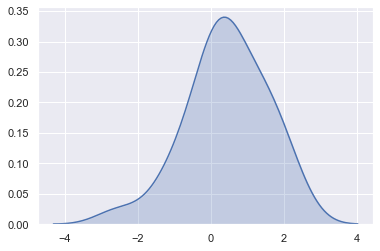

In [7]:
sns.kdeplot(x, shade=True);

**bandwidth에 따른 KDE 변화**

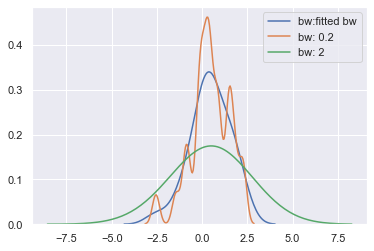

In [8]:
sns.kdeplot(x, label='bw:fitted bw')
sns.kdeplot(x, bw=.2, label="bw: 0.2")   # overfitting
sns.kdeplot(x, bw=2, label="bw: 2")      # underfitting
plt.legend()

### 사이킷런을 이용한 Mean Shift 

make_blobs()를 이용하여 2개의 feature와 3개의 군집 중심점을 가지는 임의의 데이터 200개를 생성하고 MeanShift를 이용하여 군집화 수행

In [9]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, 
                  cluster_std=0.8, random_state=0)

meanshift= MeanShift(bandwidth=0.9)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

# 군집이 0~7, 총 8개로 너무 세분화된 군집 결과

cluster labels 유형: [0 1 2 3 4 5 6 7]


**커널함수의 bandwidth크기를 1로 약간 증가 후에 Mean Shift 군집화 재 수행**

In [10]:
meanshift= MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


**최적의 bandwidth값을 estimate_bandwidth()로 계산 한 뒤에 다시 군집화 수행**

In [11]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X, quantile=0.25)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 1.689


In [12]:
# quantile 파라미터 : input data에서 사용할 데이터의 양
bw = estimate_bandwidth(X, quantile=0.5)
print('bandwidth 값:', round(bw, 3))

bandwidth 값: 3.238


In [13]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X, quantile=0.25)
print('bandwidth 값:', round(bandwidth, 3))
meanshift= MeanShift(best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:',np.unique(cluster_labels))    

bw = estimate_bandwidth(X, quantile=0.125)
print('bandwidth 값:', round(bw, 3))
meanshift2= MeanShift(bw)
cluster_labels2 = meanshift2.fit_predict(X)
print('cluster labels 유형:',np.unique(cluster_labels2)) 

bandwidth 값: 1.689
cluster labels 유형: [0 1 2]
bandwidth 값: 1.093
cluster labels 유형: [0 1 2 3]


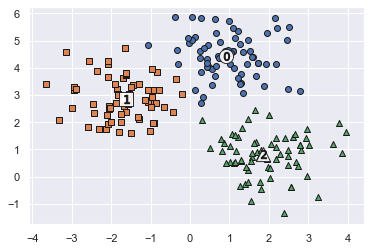

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label']  = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]
    # 군집별로 다른 marker로 scatter plot 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', 
                marker=markers[label] )
    
    # 군집별 중심 시각화
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='white',
                edgecolor='k', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', 
                marker='$%d$' % label)
    
plt.show()


In [15]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       2                  67
2       1                  65
        2                   1
Name: meanshift_label, dtype: int64


* target 2를 제외하고는 매우 군집화가 잘 됨

In [34]:
from sklearn.mixture import GaussianMixture

In [41]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
#         clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
#         clusterer = meanshift
        clusterer = GaussianMixture(n_components=n_cluster, random_state=0).fit(X_features)
#         cluster_labels = clusterer.fit_predict(X_features)
        cluster_labels = clusterer.predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [45]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
#         clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
#         clusterer = meanshift
        clusterer = GaussianMixture(n_components=n_cluster, random_state=0).fit(pca_transformed)
#         cluster_labels = clusterer.fit_predict(pca_transformed)
        cluster_labels = clusterer.predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(dataframe['cluster'])
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
%matplotlib inline

X, y = make_blobs(n_samples=200, n_features=4, centers=3, cluster_std=0.8, random_state=0)
print(X.shape, y.shape)

# y target 값의 분포를 확인
unique, counts = np.unique(y, return_counts=True)
print(unique,counts)

import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2','ftr3','ftr4'])
clusterDF['target'] = y
clusterDF.head(3)

(200, 4) (200,)
[0 1 2] [67 67 66]


,ftr1,ftr2,ftr3,ftr4,target
0,9.452330,-2.067471,6.863288,-0.627700,2
1,9.226386,-2.585204,4.528562,0.524191,2
2,2.882786,5.059371,1.325010,1.791277,0


In [27]:
# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X, quantile=0.25)
print('bandwidth 값:', round(bandwidth, 3))
meanshift= MeanShift(best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:',np.unique(cluster_labels))    

bandwidth 값: 1.689
cluster labels 유형: [0 1 2]


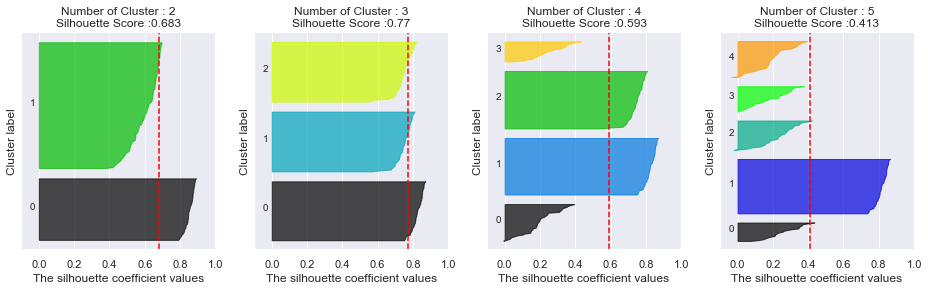

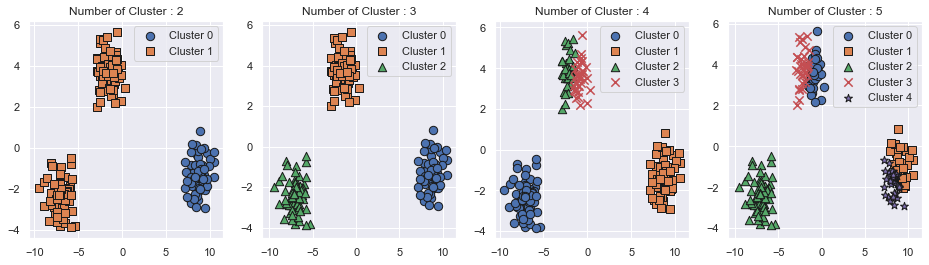

In [26]:
X_features = clusterDF.iloc[:,:5]
visualize_silhouette([2,3,4,5],X_features)
visualize_kmeans_plot_multi([2,3,4,5], X_features)

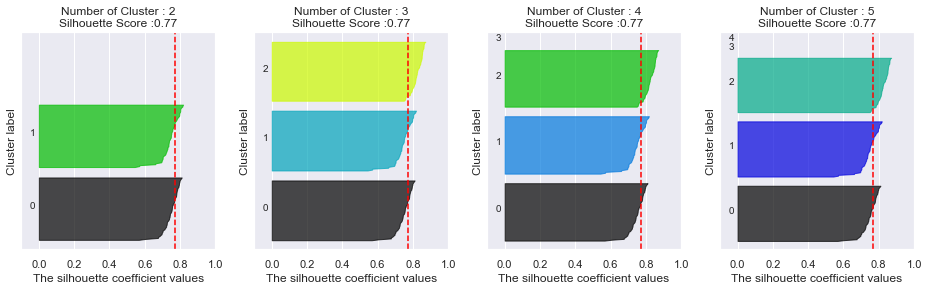

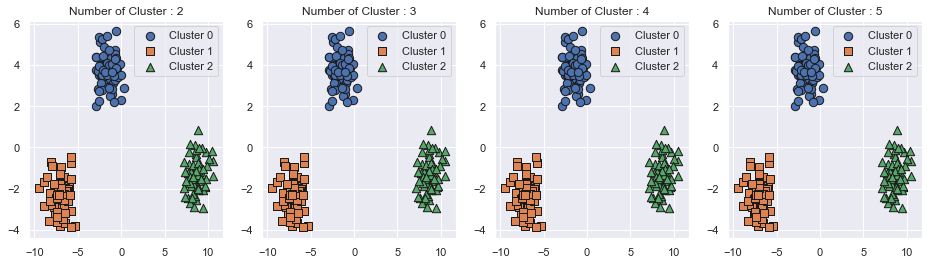

In [30]:
X_features = clusterDF.iloc[:,:5]
visualize_silhouette([2,3,4,5],X_features)
visualize_kmeans_plot_multi([2,3,4,5], X_features)

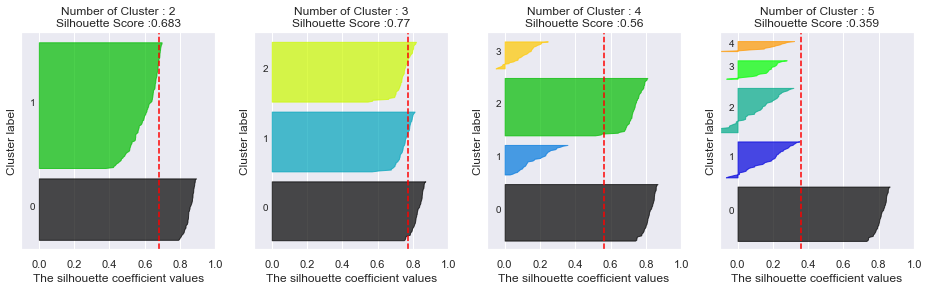

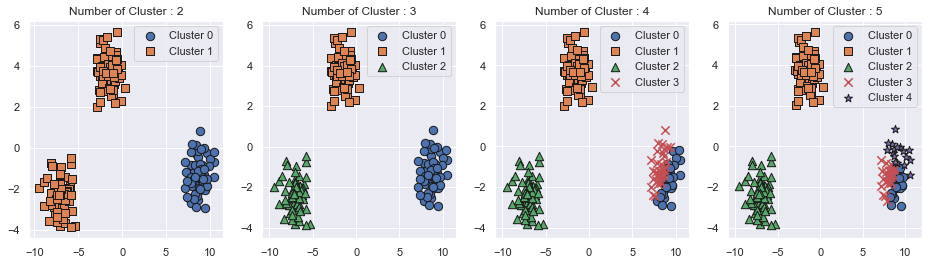

In [46]:
X_features = clusterDF.iloc[:,:5]
visualize_silhouette([2,3,4,5],X_features)
visualize_kmeans_plot_multi([2,3,4,5], X_features)

In [47]:
### 여러개의 클러스터링 개수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette_1000(cluster_model, cluster_lists, X_features): 
    
    from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN
    from sklearn.mixture import GaussianMixture
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
#         clusterer = GaussianMixture(n_components=n_cluster, random_state=0).fit(X_features)
#         cluster_labels = clusterer.fit_predict(X_features)
#         cluster_labels = clusterer.predict(X_features)
        
        if cluster_model == 'kmeans' :
            # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
            clusterer = KMeans(n_clusters = n_cluster, max_iter=300, random_state=0)
            
        elif cluster_model == 'meanshift' :
            # Mean Shift 
            # estimate_bandwidth()로 최적의 bandwidth 계산(quantile=0.25인 상태)
            best_bandwidth = estimate_bandwidth(X_features, quantile=0.25)
            print('bandwidth 값:', round(bandwidth, 3))
            clusterer= MeanShift(best_bandwidth)
            print('cluster labels :',np.unique(cluster_labels))
            
        elif cluster_model == 'gmm' :
            # GMM
            clusterer = GaussianMixture(n_components=n_cluster, random_state=0)
            
        cluster_labels = clusterer.fit_predict(X_features)
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

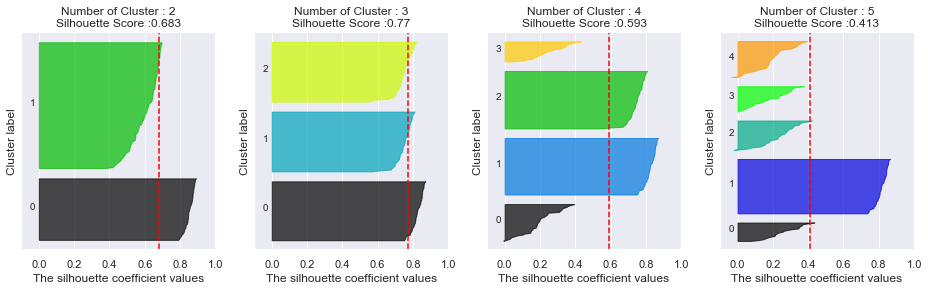

In [48]:
visualize_silhouette_1000('kmeans', [2,3,4,5], X_features)

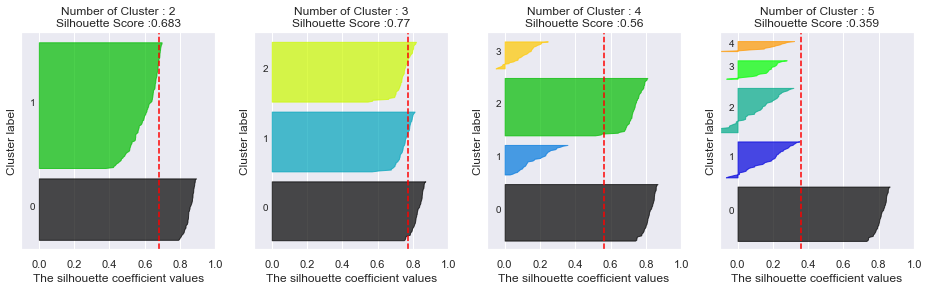

In [50]:
visualize_silhouette_1000('gmm', [2,3,4,5], X_features)